In [9]:
import os
import glob
import json
import pandas as pd
import numpy as np
import re

# --- SETTINGS ---
results_folder = "Tree2/results"
results_pattern = os.path.join(results_folder, "results_model*_*_*.csv")
json_path = "data/Tree2_v3.json"

# Specify the number of parameters for each model
model_params = {
    "model1": 6,
    "model2": 6,
    "model3": 7,
    "model4": 7,
    "model5": 5,
    "model6": 6,
    "model7": 8,
    "model8": 6,
    "model9": 8,
    "model10": 6,
    "model11": 6,
    'model12':5,
    'model13':7,
    'model14': 6,  # Added model14
    # Add more as needed
}

# Debug: Check what files are found
print(f"Looking for files matching: {results_pattern}")
files_found = glob.glob(results_pattern)
print(f"Files found: {files_found}")

# === Step 1: Load neglogl from result files ===
records = []
for file_path in glob.glob(results_pattern):
    print(f"Processing file: {file_path}")
    match = re.search(r'results_(model\d+)_\d+_\d+\.csv', os.path.basename(file_path))
    if not match:
        print(f"  No match for pattern in {os.path.basename(file_path)}")
        continue
    model = match.group(1)
    print(f"  Extracted model: {model}")
    k = model_params.get(model, None)
    if k is None:
        print(f"Warning: no parameter count specified for {model}")
        continue
    print(f"  Parameters for {model}: {k}")

    df = pd.read_csv(file_path)
    print(f"  Columns in file: {list(df.columns)}")

    if 'wid' in df.columns and 'neglogl' in df.columns:
        print(f"  Adding {len(df)} rows from {file_path}")
        for _, row in df.iterrows():
            records.append({
                'model': model,
                'wid': row['wid'],
                'neglogl': row['neglogl'],
                'k': k
            })
    else:
        print(f"  Missing required columns in {file_path}")

print(f"Total records collected: {len(records)}")
df_neglogl = pd.DataFrame(records)
print(f"DataFrame shape: {df_neglogl.shape}")

# Check if DataFrame is empty before proceeding
if df_neglogl.empty:
    print("ERROR: No data was loaded. Cannot proceed with BIC calculation.")
    print("Please check file paths and data structure.")
else:
    # === Step 2: Count trials per wid ===
    trial_counts = {}
    with open(json_path, 'r') as f:
        for line in f:
            entry = json.loads(line)
            wid = entry.get('wid')
            trial_counts[wid] = trial_counts.get(wid, 0) + 1

    df_neglogl['n_trials'] = df_neglogl['wid'].map(trial_counts)

    # === Step 3: Compute BIC ===
    df_neglogl['bic'] = df_neglogl['k'] * np.log(df_neglogl['n_trials']) + 2 * df_neglogl['neglogl']

    # === Step 4: Display results ===
    summary = df_neglogl[['model', 'wid', 'neglogl', 'k', 'n_trials', 'bic']]
    print(summary)

    # Optional: save to CSV
    # df_neglogl.to_csv('bic_summary.csv', index=False)

Looking for files matching: Tree2/results/results_model*_*_*.csv
Files found: ['Tree2/results/results_model13_20250715_213720.csv', 'Tree2/results/results_model1_20250711_215704.csv', 'Tree2/results/results_model4_20250711_104216.csv', 'Tree2/results/results_model2_20250710_110221.csv', 'Tree2/results/results_model8_20250711_200308.csv', 'Tree2/results/results_model6_20250711_005050.csv', 'Tree2/results/results_model9_20250711_014449.csv', 'Tree2/results/results_model10_20250711_210758.csv', 'Tree2/results/results_model14_20250711_213056.csv', 'Tree2/results/results_model3_20250710_170323.csv', 'Tree2/results/results_model12_20250715_164230.csv', 'Tree2/results/results_model11_20250715_105324.csv', 'Tree2/results/results_model5_20250711_164953.csv', 'Tree2/results/results_model7_20250711_012419.csv']
Processing file: Tree2/results/results_model13_20250715_213720.csv
  Extracted model: model13
  Parameters for model13: 7
  Columns in file: ['wid', 'd', 'θ0', 'vigor1', 'vigor2', 'T1', 'T


Average BIC per model (sorted by model number):
model
model1     446.682820
model2     472.175762
model3     442.893333
model4     445.641640
model5     464.624956
model6     432.796216
model7     447.855796
model8     455.921027
model9     449.219720
model10    451.755001
model11    530.063783
model12    532.742331
model13    530.176159
model14    437.149281
Name: bic, dtype: float64


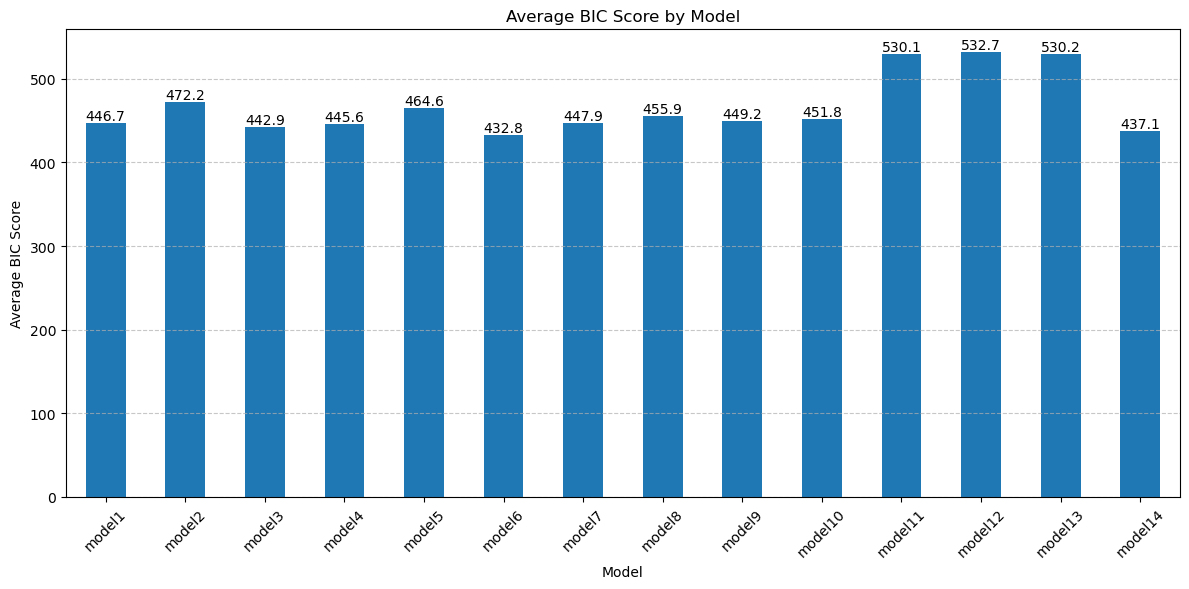

In [12]:
import matplotlib.pyplot as plt
import re

# Calculate average BIC per model
avg_bic = df_neglogl.groupby('model')['bic'].mean()

# Sort by model number (numerically)
def extract_model_number(model_name):
    match = re.search(r'model(\d+)', model_name)
    return int(match.group(1)) if match else float('inf')

avg_bic = avg_bic.sort_index(key=lambda idx: [extract_model_number(m) for m in idx])

print("\nAverage BIC per model (sorted by model number):")
print(avg_bic)

# Create bar plot
plt.figure(figsize=(12, 6))
avg_bic.plot(kind='bar')
plt.title('Average BIC Score by Model')
plt.xlabel('Model')
plt.ylabel('Average BIC Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(avg_bic):
    plt.text(i, v, f'{v:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

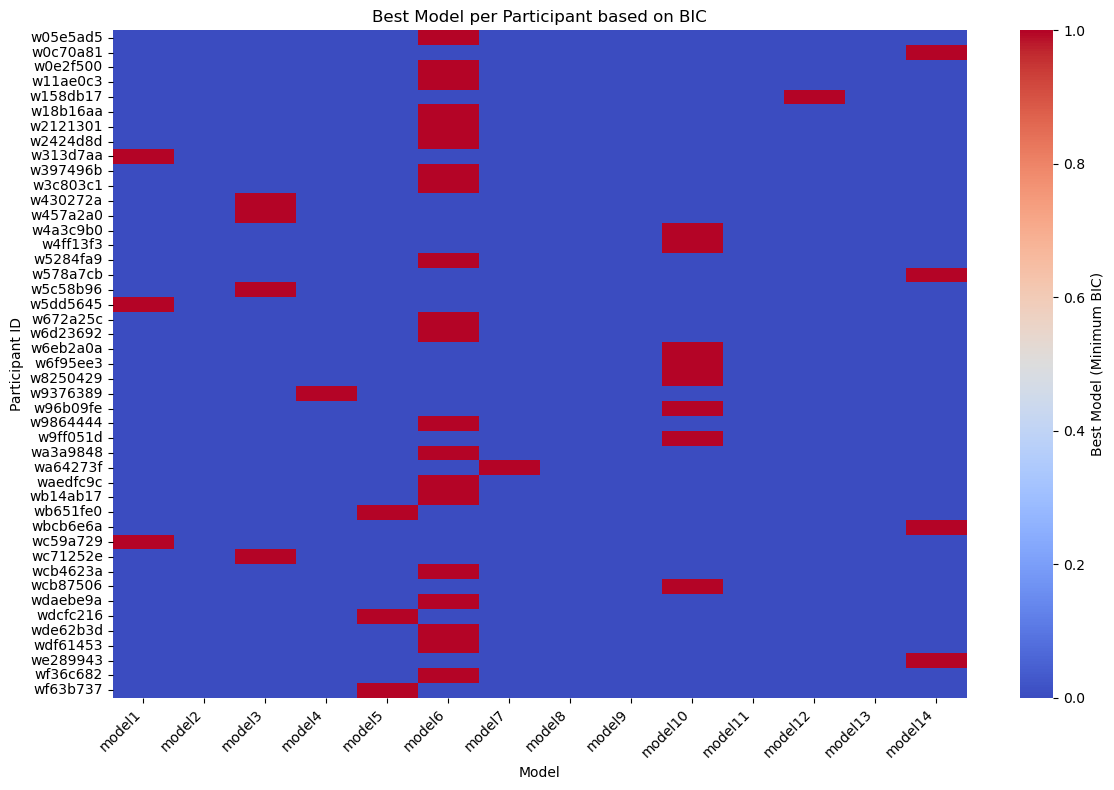

In [14]:
import seaborn as sns
import numpy as np

# Pivot the data to create a matrix of BIC scores
bic_matrix = df_neglogl.pivot(index='wid', columns='model', values='bic')

# For each participant (row), find the best model (minimum BIC)
best_model_mask = bic_matrix.eq(bic_matrix.min(axis=1), axis=0)

def extract_model_number(model_name):
    match = re.search(r'model(\d+)', model_name)
    return int(match.group(1)) if match else float('inf')

# Sort columns by model number
sorted_columns = sorted(bic_matrix.columns, key=extract_model_number)
bic_matrix_sorted = bic_matrix[sorted_columns]

# For each participant (row), find the best model (minimum BIC)
best_model_mask = bic_matrix_sorted.eq(bic_matrix_sorted.min(axis=1), axis=0)

# Create a figure
plt.figure(figsize=(12, 8))

# Create heatmap
sns.heatmap(best_model_mask, 
            cmap='coolwarm',
            cbar_kws={'label': 'Best Model (Minimum BIC)'},
            yticklabels=True)

plt.title('Best Model per Participant based on BIC')
plt.xlabel('Model')
plt.ylabel('Participant ID')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()


In [10]:
summary

,model,wid,neglogl,k,n_trials,bic
0,model13,w3c803c1,382.987782,7,140,800.567061
1,model13,wdaebe9a,265.773190,7,95,563.423518
2,model13,w457a2a0,151.760057,7,95,335.397251
3,model13,wc71252e,314.141035,7,87,659.543427
4,model13,w8250429,330.061058,7,88,691.463474
...,...,...,...,...,...,...
625,model7,w6d23692,296.334072,8,140,632.201284
626,model7,we289943,241.161795,8,141,521.913669
627,model7,w6f95ee3,262.654877,8,145,565.123623
628,model7,w6eb2a0a,184.916201,8,75,404.372307
